## Hierarchical Model

In [54]:
import os
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reliability.Fitters import Fit_Weibull_2P
from cycler import cycler
plt.style.use('ggplot')

from scipy.stats import exponweib
import arviz as az

In [55]:
data = []
files = os.listdir('data')
files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
for i, file in enumerate(files):
    file_data = np.loadtxt('data/' + file, delimiter=',')
    file_data = np.column_stack((file_data, np.ones(file_data.shape[0]) * i))
    data.append(file_data)
data = np.concatenate(data)

strength = data[:, 0].flatten()
batch = data[:, 1].astype(int).flatten()
coords = {'batch': [str(n) for n in range(i+1)]}

print(strength[:5])
print(batch[:5])
print(coords)


[540.33463682 946.85290322 907.04393091 930.4802949  930.01921226]
[0 0 0 0 0]
{'batch': ['0', '1', '2', '3', '4']}


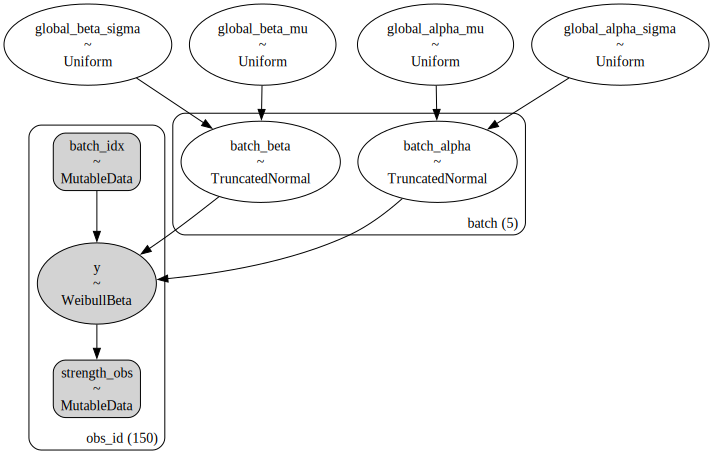

In [56]:
with pm.Model(coords=coords) as HWeib_model:
    batch_idx = pm.MutableData("batch_idx", batch, dims='obs_id')
    strength_obs = pm.MutableData("strength_obs", strength, dims='obs_id')

    global_alpha_mu = pm.Uniform("global_alpha_mu", lower=1, upper=25)
    global_beta_mu = pm.Uniform("global_beta_mu", lower=100, upper=2000)

    global_alpha_sigma = pm.Uniform("global_alpha_sigma", lower=0.5, upper=8)
    global_beta_sigma = pm.Uniform("global_beta_sigma", lower=5, upper=50)

    batch_alpha = pm.TruncatedNormal("batch_alpha", mu=global_alpha_mu, sigma=global_alpha_sigma, lower=0, dims="batch")
    batch_beta = pm.TruncatedNormal("batch_beta", mu=global_beta_mu, sigma=global_beta_sigma, lower=0, dims="batch")

    alpha = batch_alpha[batch_idx]
    beta = batch_beta[batch_idx]

    y = pm.Weibull("y", alpha=alpha, beta=beta, observed=strength_obs, dims="obs_id")

pm.model_to_graphviz(HWeib_model, )

In [57]:
with HWeib_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(tune=15000, draws=10000, target_accept=0.99))
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [batch_alpha, batch_beta, global_alpha_mu, global_alpha_sigma, global_beta_mu, global_beta_sigma, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_alpha_mu, global_beta_mu, global_alpha_sigma, global_beta_sigma, batch_alpha, batch_beta]


Sampling 4 chains for 15_000 tune and 10_000 draw iterations (60_000 + 40_000 draws total) took 147 seconds.
Sampling: [y]


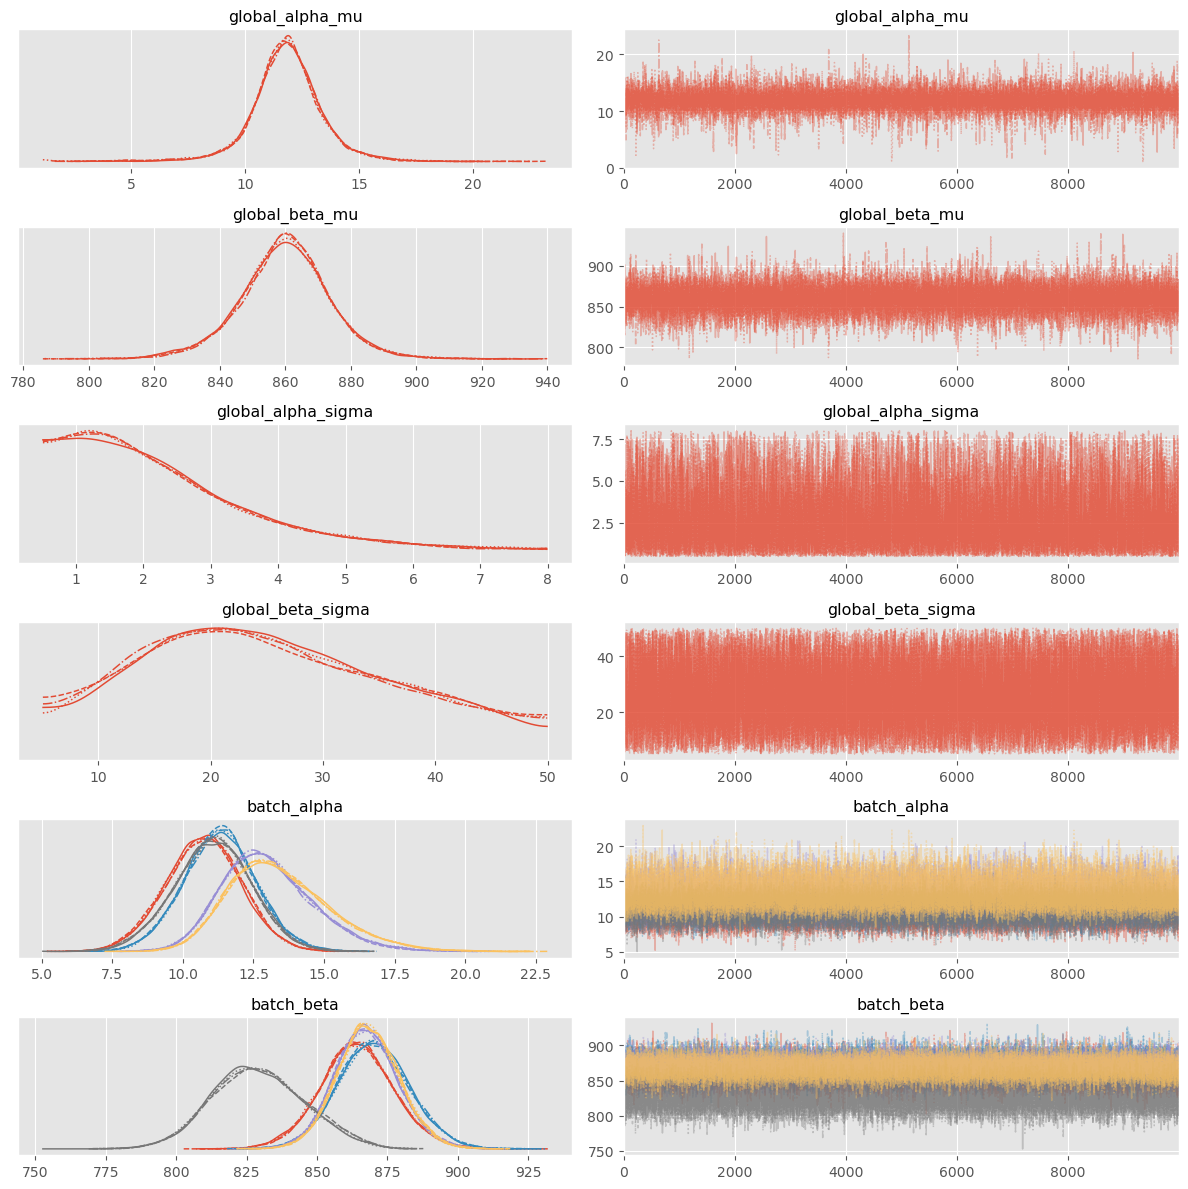

In [58]:
# plot the results
az.plot_trace(idata)
plt.tight_layout()
plt.show()

In [60]:
res = az.summary(idata.posterior, stat_focus='mean')
display(res)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_alpha_mu,11.817,1.618,8.873,14.949,0.015,0.011,15305,11122,1
global_beta_mu,859.855,13.954,832.471,886.05,0.092,0.065,23588,23985,1
global_alpha_sigma,2.491,1.626,0.5,5.726,0.017,0.012,9006,12655,1
global_beta_sigma,25.252,11.006,5.577,44.745,0.093,0.066,13185,16783,1
batch_alpha[0],10.734,1.332,8.171,13.194,0.009,0.006,23099,24578,1
batch_alpha[1],11.309,1.284,8.794,13.66,0.008,0.006,26475,23523,1
batch_alpha[2],13.002,1.628,10.165,16.18,0.012,0.008,20494,26514,1
batch_alpha[3],11.055,1.378,8.426,13.621,0.009,0.006,24437,22463,1
batch_alpha[4],13.421,1.79,10.265,16.863,0.013,0.009,18780,25017,1
batch_beta[0],864.205,13.21,839.529,889.751,0.08,0.057,27067,27429,1
